# Sentiment mining: corona tweets
- Pauline Claes. 
- Machine Learning 1 project 
- Friday 22 January 2021


## Preprocessing

In [105]:
# import packages
import pandas as pd
import numpy as np

In [74]:
# import modules
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import naive_bayes
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from nltk.tokenize import word_tokenize 
import matplotlib.pyplot as plt
nltk__word_tokenizer = word_tokenize

In [3]:
# read in the data
df = pd.read_csv("corona-tweets.csv", sep=",")

In [4]:
# inspect
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [5]:
# inspect
df.tail()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
41153,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41154,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41155,44953,89905,NaN,14-04-2020,You know its getting tough when @KameronWilds...,Positive
41156,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral
41157,44955,89907,i love you so much || he/him,14-04-2020,@TartiiCat Well new/used Rift S are going for ...,Negative


In [6]:
# inspect
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41158 entries, 0 to 41157
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41158 non-null  int64 
 1   ScreenName     41158 non-null  int64 
 2   Location       32492 non-null  object
 3   TweetAt        41158 non-null  object
 4   OriginalTweet  41158 non-null  object
 5   Sentiment      41158 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [7]:
# check to see if there are any missing values
df.isnull().sum()

UserName            0
ScreenName          0
Location         8666
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [8]:
# drop rows containing missing values
df = df.dropna()
# check to see if it worked
df.isnull().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

In [9]:
# check to see what we have left
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32492 entries, 0 to 41157
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       32492 non-null  int64 
 1   ScreenName     32492 non-null  int64 
 2   Location       32492 non-null  object
 3   TweetAt        32492 non-null  object
 4   OriginalTweet  32492 non-null  object
 5   Sentiment      32492 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.7+ MB


In [10]:
# check to see if the labels are stratified
df.Sentiment.value_counts()

Positive              9024
Negative              7800
Neutral               6134
Extremely Positive    5301
Extremely Negative    4233
Name: Sentiment, dtype: int64

In [11]:
# merge Extremely Positive and Positive
df['Sentiment'] = df.Sentiment.str.replace('Extremely Positive', 'Positive')
# merge Extremely Negative and Negative
df['Sentiment'] = df.Sentiment.str.replace('Extremely Negative', 'Negative')

In [12]:
# check to see if it worked
df.Sentiment.value_counts()

Positive    14325
Negative    12033
Neutral      6134
Name: Sentiment, dtype: int64

In [13]:
# take half of the data for computational efficiency by stating frac=0.5
# create replicability by random_state=42
tweets = df.sample(frac=0.5, random_state=42)

In [14]:
# check if they are still correctly stratified
tweets.Sentiment.value_counts()

Positive    7140
Negative    6013
Neutral     3093
Name: Sentiment, dtype: int64

In [15]:
# set the value_counts equal to each other again
min_number = np.min(tweets.Sentiment.value_counts())
tweets = tweets.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(min_number))

In [16]:
# check to see if it worked
tweets.Sentiment.value_counts()

Positive    3093
Negative    3093
Neutral     3093
Name: Sentiment, dtype: int64

In [17]:
# divide subset of data into train and test part
from sklearn.model_selection import train_test_split

X = tweets["OriginalTweet"].values # input feature
y = tweets["Sentiment"].values # label

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, # 20% test data
                                                    random_state = 42, # replicable results
                                                    shuffle = True, # shuffle
                                                    stratify = y) # stratify

In [19]:
# split up train part into a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                 test_size = 0.25,
                                                 random_state = 42,
                                                 shuffle = True, 
                                                 stratify = y_train)

In [20]:
# check the shapes of the train and test data)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_val.shape, y_test.shape

((5567,), (1856,), (1856,), (5567,), (1856,), (1856,))

We now have: 
- X_train: originally 80% of input instances from our total dataset. This is what we will use to train the model on the input.
    - X_val: 25% of our input training part. This is what we will use to test our model's ability to generalize to unseen datapoints.
- y_train: originally 80% of output labels from our total dataset. This is what we will use to train the model on the desired output.
    - y_val: 25% of our output training part. This is what we will use to compare the predictions of the model to the desired output.
- X_test: 20% of the input instances from our total dataset. This is the part of the data that we will keep apart until the very end, to test our final (best-performing) model on its performance to generalize to unseen data.
- y_test: 20% of the output instances from our total dataset. We will keep this part of the data separated until the very end, to compare the model's predictions on X_test to the actual desired output.

If we would only have a train and a test set, the test set will eventually become part of the training set if we try it out multiple times and the scores might not be reliable (too optimistic) anymore. Therefore, it is useful to create a validation set. We take 25% of the training set to create a validation set. This is the set that will be used to test each of the models' performance right after training. Only at the end, we will use our test set to assess our best performing model's ability to generalize to unseen data.

# Pipeline 1. CountVectorizer and SGDClassifier
This pipeline includes CountVectorizer with max_features set to 10,000 and the NLTK word tokenizer, as well as the Stochastic Gradient Descent classifier with its default parameters, a log loss function and a random_state. The other default parameters include alpha set to 0.0001, max_iter set to 1000 and l2 penalty. Judging by the classification report, this pipeline performed relatively well, obtaining a macro average f1-score of 0.69.  The boxplot of the cross_val_score shows a mor conservative mean macro average f1-score for the cross-validation, of around 0.66. Both the classification report and the confusion matrix seem to point toward a slightly better performance on the “Neutral” class.

In [21]:
# default parameters of CountVectorizer that we might want to optimize
CountVectorizer().get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [22]:
# default parameters of SGDClassifier that we might want to optimize.
SGDClassifier().get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [23]:
# instantiate a CountVectorizer
cvect = CountVectorizer(max_features=10000, # 10,000 most frequent words
                        tokenizer = nltk__word_tokenizer) # word tokenizer imported from NLTK
                          

# instantiate an SGDClassifier with default parameters and log loss function
sgdclf = SGDClassifier(loss = 'log', random_state=42)

# Instantiate the pipeline
pipeline1 = make_pipeline(cvect, sgdclf)

In [24]:
#pipeline1.get_params()

In [25]:
# fit the training data to the pipeline
pipeline1.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=10000,
                                 tokenizer=<function word_tokenize at 0x7fd01ee6eee0>)),
                ('sgdclassifier', SGDClassifier(loss='log', random_state=42))])

In [26]:
# fit the test input to the pipeline to predict the classes on unseen data
y_pred1 = pipeline1.predict(X_val)

In [27]:
print(classification_report(y_val, y_pred1))

              precision    recall  f1-score   support

    Negative       0.76      0.63      0.69       619
     Neutral       0.63      0.80      0.70       619
    Positive       0.72      0.65      0.68       618

    accuracy                           0.69      1856
   macro avg       0.70      0.69      0.69      1856
weighted avg       0.70      0.69      0.69      1856



In [28]:
%time scores = cross_val_score(estimator=pipeline1, X=X_train, y=y_train, cv=10, scoring='f1_macro', n_jobs=-1)


CPU times: user 92.6 ms, sys: 95.1 ms, total: 188 ms
Wall time: 4.09 s


<AxesSubplot:>

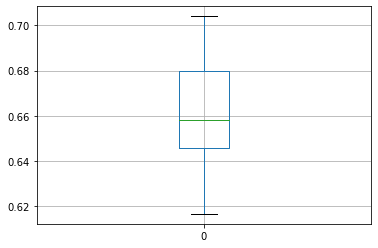

In [29]:
pd.DataFrame(scores).boxplot()

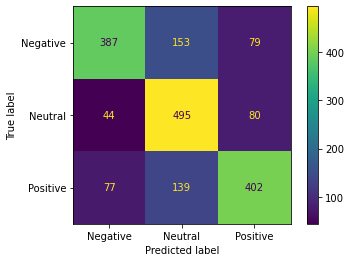

In [30]:
fig, ax = plt.subplots()
plot_confusion_matrix(pipeline1, 
                      X_val,
                      y_val,
                      labels=pipeline1.classes_, 
                      ax = ax)
plt.show()

# Pipeline 2. CountVectorizer and Support Vector Machines
This pipeline includes the CountVectorizer with max_features set to 10,000 and the NLTK word tokenizer, as well as the Support Vector Machine classifier with its default parameters. These include C set to 1.0, gamma set to ‘scale’, an RBF-kernel (Radial Basis Function) and max_iter set to -1 (no limit). The classification report indicates that this pipeline’s performance is relatively unsatisfying, reaching a macro average f1-score of 0.60. Furthermore, the cross_val_score boxplot estimates the mean macro average f1-score for the cross-validation slightly around 0.59. Both the classification report and the confusion matrix show a slightly better performance on the “Neutral” class.

In [31]:
# check the default parameters
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [32]:
# build pipeline
cvect = CountVectorizer(max_features = 10000, 
                          tokenizer = nltk__word_tokenizer)

svm = SVC(random_state=42)

pipeline2 = make_pipeline(cvect, svm)

In [33]:
# fit
pipeline2.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=10000,
                                 tokenizer=<function word_tokenize at 0x7fd01ee6eee0>)),
                ('svc', SVC(random_state=42))])

In [34]:
# predict
y_pred2 = pipeline2.predict(X_val)

In [35]:
print(classification_report(y_val, y_pred2))

              precision    recall  f1-score   support

    Negative       0.65      0.55      0.59       619
     Neutral       0.60      0.71      0.65       619
    Positive       0.58      0.55      0.56       618

    accuracy                           0.60      1856
   macro avg       0.61      0.60      0.60      1856
weighted avg       0.61      0.60      0.60      1856



In [36]:
%time scores2 = cross_val_score(estimator=pipeline2, X=X_train, y=y_train, cv=10, scoring='f1_macro', n_jobs=-1)

CPU times: user 46.8 ms, sys: 6.16 ms, total: 52.9 ms
Wall time: 14.2 s


<AxesSubplot:>

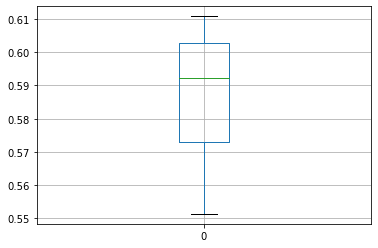

In [37]:
pd.DataFrame(scores2).boxplot()

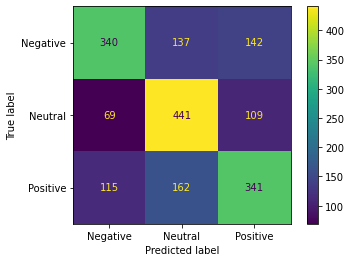

In [38]:
fig, ax = plt.subplots()
plot_confusion_matrix(pipeline2, 
                      X_val,
                      y_val,
                      labels=pipeline2.classes_, 
                      ax = ax)
plt.show()

# Pipeline 3. CountVectorizer and Naive Bayes Classifier
This pipeline combines the CountVectorizer with max_features set to 10,000 and the NLTK word tokenizer and a multinomial Naïve Bayes classifier with its default parameters, which has alpha set to 1.0. However, it does not support the use of random_state, therefore it is not instantiated. This pipeline reaches a macro average f1-score of 0.64 in the classification report, which indicates that it performs better than the second pipeline, without outperforming the first one. The cross_val_score boxplot indicates that the mean macro average f1-score for the cross-validation is slightly around 0.62. The classification report as well as the confusion matrix show a slightly better performance on the “Negative” class.

In [40]:
# get parameters
naive_bayes.MultinomialNB().get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [39]:
# build pipeline
cvect = CountVectorizer(max_features = 10000, 
                          tokenizer = nltk__word_tokenizer)

nbc = naive_bayes.MultinomialNB()

pipeline3 = make_pipeline(cvect, nbc)

In [41]:
# fit training data
pipeline3.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=10000,
                                 tokenizer=<function word_tokenize at 0x7fd01ee6eee0>)),
                ('multinomialnb', MultinomialNB())])

In [42]:
# predict on validation data
y_pred3 = pipeline3.predict(X_val)

In [43]:
print(classification_report(y_val, y_pred3))

              precision    recall  f1-score   support

    Negative       0.65      0.68      0.66       619
     Neutral       0.65      0.61      0.63       619
    Positive       0.63      0.65      0.64       618

    accuracy                           0.64      1856
   macro avg       0.64      0.64      0.64      1856
weighted avg       0.64      0.64      0.64      1856



In [44]:
%time scores3 = cross_val_score(estimator=pipeline3, X=X_train, y=y_train, cv=10, scoring='f1_macro', n_jobs=-1)


CPU times: user 39.9 ms, sys: 5.35 ms, total: 45.3 ms
Wall time: 2.54 s


<AxesSubplot:>

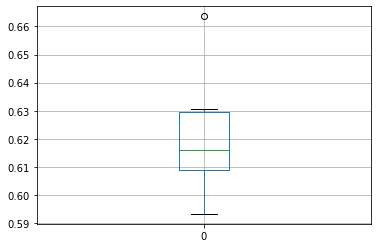

In [45]:
pd.DataFrame(scores3).boxplot()

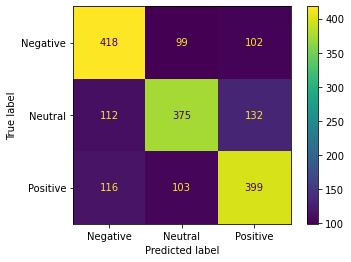

In [46]:
fig, ax = plt.subplots()
plot_confusion_matrix(pipeline3, 
                      X_val,
                      y_val,
                      labels=pipeline3.classes_, 
                      ax = ax)
plt.show()

# Pipeline 4. TF-IDF Vectorizer and SGDClassifier
This pipeline includes the Tf-Idf Vectorizer with max_features set to 10,000 and the NLTK word tokenizer, as well as the Stochastic Gradient Descent classifier with its default parameters, log loss function and a random_state. The default parameters of the SGDClassifier include alpha set to 0.0001, max_iter set to 1000 and l2 penalty. The classification report points toward a macro average f1-score of 0.69, while the cross_val_score boxplot estimates a mean macro average f1-score for the cross-validation of approximately 0.67. It seems that there is a slightly better performance on the “Neutral” class in terms of recall. 

In [47]:
# get default parameters
TfidfVectorizer().get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [48]:
# get default parameters
SGDClassifier().get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [49]:
# build pipeline
tvect = TfidfVectorizer(max_features=10000, 
                          tokenizer = nltk__word_tokenizer)

# sgdclassifier with default parameters and log loss function
sgdclf = SGDClassifier(loss = 'log', random_state = 42) 

pipeline4 = make_pipeline(tvect, sgdclf)

In [50]:
# fit 
pipeline4.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000,
                                 tokenizer=<function word_tokenize at 0x7fd01ee6eee0>)),
                ('sgdclassifier', SGDClassifier(loss='log', random_state=42))])

In [51]:
# predict
y_pred4 = pipeline4.predict(X_val)

In [52]:
print(classification_report(y_val, y_pred4))

              precision    recall  f1-score   support

    Negative       0.72      0.67      0.70       619
     Neutral       0.64      0.74      0.69       619
    Positive       0.70      0.65      0.67       618

    accuracy                           0.69      1856
   macro avg       0.69      0.69      0.69      1856
weighted avg       0.69      0.69      0.69      1856



In [53]:
%time scores4 = cross_val_score(estimator=pipeline4, X=X_train, y=y_train, cv=10, scoring='f1_macro', n_jobs=-1)


CPU times: user 48.9 ms, sys: 7.64 ms, total: 56.6 ms
Wall time: 2.49 s


<AxesSubplot:>

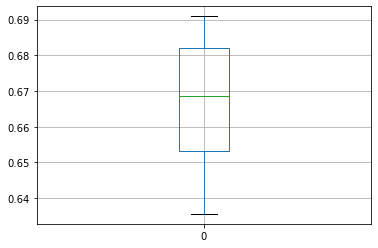

In [54]:
pd.DataFrame(scores4).boxplot()

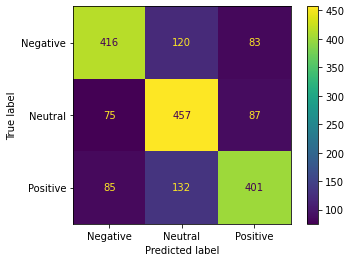

In [55]:
fig, ax = plt.subplots()
plot_confusion_matrix(pipeline4, 
                      X_val,
                      y_val,
                      labels=pipeline4.classes_, 
                      ax = ax)
plt.show()

# Pipeline 5. TF-IDF Vectorizer and Support Vector Machine
In this pipeline, we combine the Tf-Idf Vectorizer with max_features set to 10,000 and the NLTK word tokenizer, as well as the Support Vector Machines classifier with its default parameters, which include C set to 1.0, gamma set to ‘scale’, an RBF-kernel (Radial Basis Function) and max_iter set to -1 (no limit). Reaching a macro average f1-score of 0.66, this model is rather mediocre. The boxplot for the cross-validation confirms this by indicating a mean macro average f1-score of around 0.64. The confusion matrix indicates that the model performs slightly better on the “Neutral” class.

In [31]:
# check the default parameters
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [56]:
# get parameters
TfidfVectorizer().get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [57]:
# build pipeline
tfidf = TfidfVectorizer(max_features = 10000, 
                        tokenizer = nltk__word_tokenizer)

svm = SVC(random_state=42) # with default parameters: rbf, C=1.0, gamma='scale'

pipeline5 = make_pipeline(tfidf, svm)

In [58]:
# fit 
pipeline5.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000,
                                 tokenizer=<function word_tokenize at 0x7fd01ee6eee0>)),
                ('svc', SVC(random_state=42))])

In [59]:
# predict
y_pred5 = pipeline5.predict(X_val)

In [60]:
print(classification_report(y_val, y_pred5))

              precision    recall  f1-score   support

    Negative       0.68      0.64      0.66       619
     Neutral       0.64      0.71      0.67       619
    Positive       0.66      0.63      0.64       618

    accuracy                           0.66      1856
   macro avg       0.66      0.66      0.66      1856
weighted avg       0.66      0.66      0.66      1856



In [61]:
%time scores5 = cross_val_score(estimator=pipeline5, X=X_train, y=y_train, cv=10, scoring='f1_macro', n_jobs=-1)

CPU times: user 43.2 ms, sys: 5.28 ms, total: 48.5 ms
Wall time: 14.6 s


<AxesSubplot:>

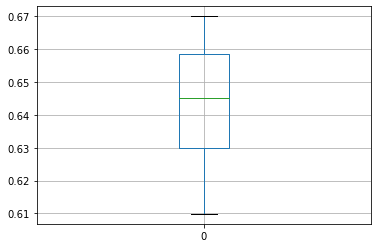

In [62]:
pd.DataFrame(scores5).boxplot()

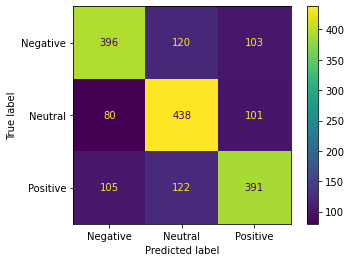

In [63]:
fig, ax = plt.subplots()
plot_confusion_matrix(pipeline5, 
                      X_val,
                      y_val,
                      labels=pipeline5.classes_, 
                      ax = ax)
plt.show()

# Pipeline 6. TF-IDF Vectorizer and multinomial Naive Bayes Classifier
In this pipeline, we include the Tf-Idf Vectorizer with max_features set to 10,000 and the NLTK word tokenizer, together with a multinomial Naïve Bayes classifier with its default parameters. This classifier does not support the use of random_state (replicability), so it is not instantiated. Judging by the classification report, this pipeline also covers mediocre ground, reaching a macro average f1-score of 0.65. This slightly outperforms the pipeline with CountVectorizer and multinomial Naïve Bayes classifier, and this is also reflected in the mean macro average f1-score of 0.63 in the cross_val_score boxpot. The confusion matrix indicates that this pipeline slightly underperforms on the “Neutral” class.

In [64]:
# get parameters
naive_bayes.MultinomialNB().get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [65]:
# build pipeline
tvect = TfidfVectorizer(max_features=10000, 
                          tokenizer = nltk__word_tokenizer)

nbc = naive_bayes.MultinomialNB() # NBC with default parameters

pipeline6 = make_pipeline(tvect, nbc)

In [66]:
pipeline6.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000,
                                 tokenizer=<function word_tokenize at 0x7fd01ee6eee0>)),
                ('multinomialnb', MultinomialNB())])

In [67]:
# predict
y_pred6 = pipeline6.predict(X_val)

In [68]:
print(classification_report(y_val, y_pred6))

              precision    recall  f1-score   support

    Negative       0.64      0.69      0.67       619
     Neutral       0.69      0.55      0.62       619
    Positive       0.61      0.69      0.65       618

    accuracy                           0.65      1856
   macro avg       0.65      0.65      0.65      1856
weighted avg       0.65      0.65      0.65      1856



In [69]:
%time scores6 = cross_val_score(estimator=pipeline6, X=X_train, y=y_train, cv=10, scoring='f1_macro', n_jobs=-1)

CPU times: user 42.6 ms, sys: 5.71 ms, total: 48.3 ms
Wall time: 2.41 s


<AxesSubplot:>

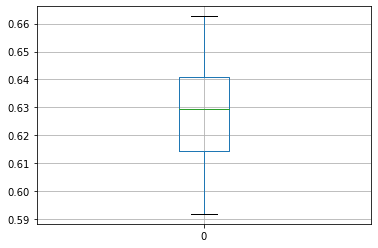

In [70]:
pd.DataFrame(scores6).boxplot()

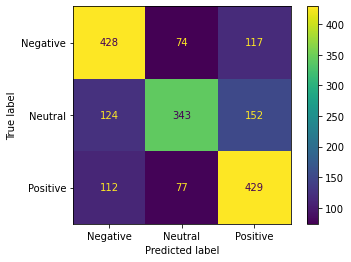

In [71]:
fig, ax = plt.subplots()
plot_confusion_matrix(pipeline6, 
                      X_val,
                      y_val,
                      labels=pipeline6.classes_, 
                      ax = ax)
plt.show()

# Hyperparameter tuning using grid search on pipeline 1 and 4
In this section, we will perform hyperparameter optimization on the two pipelines that performed the best in terms of macro average f1-score. This way, we will find the optimal parameters for our classification task. Pipeline 1 (CountVectorizer and Stochastic Gradient Descent classifier) and pipeline 4 (Tf-Idf Vectorizer and Stochastic Gradient Descent classifier) both obtained a macro-average f1-score of 0.69. That is why we will perform grid search on both of them. After that, the grid search that performs best on the validation set will be used to assess the final performance on the test set that has been kept apart until now.

## Grid search on pipeline 1. CountVectorizer and Stochastic Gradient Descent classifier

In this grid search, we define a parameter grid to find the optimal values for two parameters in the CountVectorizer and four parameters in the SGDClassifier. For CountVectorizer, the grid search will find the best value for max_features and min_df. For SGDClassifier, the grid search optimizes alpha and max_iter, as well as the loss function and the penalty function.

In [72]:
pipeline1.get_params() #  get all the parameters from the previously built pipeline

{'memory': None,
 'steps': [('countvectorizer',
   CountVectorizer(max_features=10000,
                   tokenizer=<function word_tokenize at 0x7fd01ee6eee0>)),
  ('sgdclassifier', SGDClassifier(loss='log', random_state=42))],
 'verbose': False,
 'countvectorizer': CountVectorizer(max_features=10000,
                 tokenizer=<function word_tokenize at 0x7fd01ee6eee0>),
 'sgdclassifier': SGDClassifier(loss='log', random_state=42),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': 10000,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pa

In [77]:
# define parameter grid
params1 = [{'countvectorizer__max_features': [5000, 10000, 30000],
           'countvectorizer__min_df': [1, 0.2, 0.5],
           'sgdclassifier__alpha': [1e-4, 0.001, 0.01, 0.1],
           'sgdclassifier__max_iter': [100, 1000, 10000],
           'sgdclassifier__loss': ['hinge', 'log'],
           'sgdclassifier__penalty': ['l2', 'l1', 'elasticnet']}]

# define gridsearch
gs1 = GridSearchCV(estimator = pipeline1,
                  param_grid = params1,
                  scoring = "f1_macro", 
                  cv = 10,
                  n_jobs = -1,
                  refit=True)

In [78]:
# fit training data to gridsearch
gs1.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(max_features=10000,
                                                        tokenizer=<function word_tokenize at 0x7fd01ee6eee0>)),
                                       ('sgdclassifier',
                                        SGDClassifier(loss='log',
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid=[{'countvectorizer__max_features': [5000, 10000, 30000],
                          'countvectorizer__min_df': [1, 0.2, 0.5],
                          'sgdclassifier__alpha': [0.0001, 0.001, 0.01, 0.1],
                          'sgdclassifier__loss': ['hinge', 'log'],
                          'sgdclassifier__max_iter': [100, 1000, 10000],
                          'sgdclassifier__penalty': ['l2', 'l1',
                                                     'elasticnet']}],
         

In [79]:
# check what the gridsearch has found to be the best parameters for this task
gs1.best_params_

{'countvectorizer__max_features': 10000,
 'countvectorizer__min_df': 1,
 'sgdclassifier__alpha': 0.001,
 'sgdclassifier__loss': 'hinge',
 'sgdclassifier__max_iter': 100,
 'sgdclassifier__penalty': 'l1'}

In [80]:
# best score obtained by grid search
gs1.best_score_

0.6940332989944528

In [81]:
# predict with grid search on validation set
y_pred_gs1 = gs1.predict(X_val)

In [82]:
print(classification_report(y_val, y_pred_gs1))

              precision    recall  f1-score   support

    Negative       0.78      0.64      0.70       619
     Neutral       0.63      0.88      0.74       619
    Positive       0.80      0.64      0.71       618

    accuracy                           0.72      1856
   macro avg       0.74      0.72      0.72      1856
weighted avg       0.74      0.72      0.72      1856



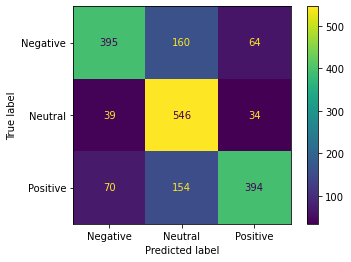

In [84]:
plot_confusion_matrix(gs1, X_val, y_val, labels=gs1.classes_)
plt.show()

## Grid search on pipeline 4. Tf-Idf Vectorizer and SGDClassifier
Here, we will define the parameter grid to find the best values for two parameters in Tf-Idf Vectorizer as well as four parameters in the SGDClassifier. The hyperparameters that the grid search will optimize are the same as in the previous grid search: max_features and min_df for Tf-Idf Vectorizer and alpha, max_iter, loss function and penalty function for the SGDClassifier. 

In [85]:
# get parameters of pipeline we built earlier
pipeline4.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer',
   TfidfVectorizer(max_features=10000,
                   tokenizer=<function word_tokenize at 0x7fd01ee6eee0>)),
  ('sgdclassifier', SGDClassifier(loss='log', random_state=42))],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(max_features=10000,
                 tokenizer=<function word_tokenize at 0x7fd01ee6eee0>),
 'sgdclassifier': SGDClassifier(loss='log', random_state=42),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': 10000,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': No

In [86]:
# define parameter grid
params2 = [{'tfidfvectorizer__max_features': [5000, 10000, 30000],
           'tfidfvectorizer__min_df': [1, 0.2, 0.5], 
           'sgdclassifier__alpha': [1e-4, 0.001, 0.01, 0.1],
           'sgdclassifier__max_iter': [100, 1000, 10000],
           'sgdclassifier__loss': ['hinge', 'log'],
           'sgdclassifier__penalty': ['l2', 'l1', 'elasticnet']}]
# define grid search
gs2 = GridSearchCV(estimator = pipeline4,
                  param_grid = params2,
                  scoring = "f1_macro", 
                  cv = 10,
                  n_jobs = -1,
                  refit=True)

In [87]:
# fit training data to the grid search
gs2.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(max_features=10000,
                                                        tokenizer=<function word_tokenize at 0x7fd01ee6eee0>)),
                                       ('sgdclassifier',
                                        SGDClassifier(loss='log',
                                                      random_state=42))]),
             n_jobs=-1,
             param_grid=[{'sgdclassifier__alpha': [0.0001, 0.001, 0.01, 0.1],
                          'sgdclassifier__loss': ['hinge', 'log'],
                          'sgdclassifier__max_iter': [100, 1000, 10000],
                          'sgdclassifier__penalty': ['l2', 'l1', 'elasticnet'],
                          'tfidfvectorizer__max_features': [5000, 10000, 30000],
                          'tfidfvectorizer__min_df': [1, 0.2, 0.5]}],
             scoring='f1_macro')

In [88]:
# check what values the grid search found to be optimal for our task
gs2.best_params_

{'sgdclassifier__alpha': 0.0001,
 'sgdclassifier__loss': 'hinge',
 'sgdclassifier__max_iter': 100,
 'sgdclassifier__penalty': 'l1',
 'tfidfvectorizer__max_features': 10000,
 'tfidfvectorizer__min_df': 1}

In [89]:
# check the best score that gridsearch obtained
gs2.best_score_

0.7251057317583959

In [90]:
# predict
y_pred_gs2 = gs2.predict(X_val)

In [91]:
print(classification_report(y_val, y_pred_gs2))

              precision    recall  f1-score   support

    Negative       0.81      0.71      0.76       619
     Neutral       0.70      0.85      0.77       619
    Positive       0.80      0.73      0.76       618

    accuracy                           0.76      1856
   macro avg       0.77      0.76      0.76      1856
weighted avg       0.77      0.76      0.76      1856



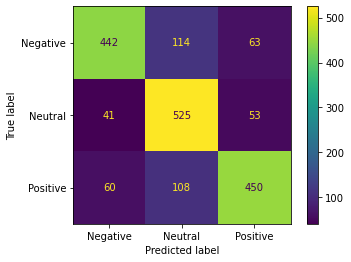

In [92]:
plot_confusion_matrix(gs2, X_val, y_val, labels=gs1.classes_)
plt.show()

# Building a pipeline with the new parameters for Tf-Idf Vectorizer and SGDClassifier, retraining and testing
In the section above, it was clear that Tf-Idf Vectorizer and Stochastic Gradient Descent classifier resulted in the best performance after hyperparameter optimization, yielding a macro average f1-score of 0.76. Therefore, we will use this model to assess the final performance on the test set, that has been kept apart until now. In order to do this, we build a new pipeline and specify the optimal parameters for the vectorizer and classifier. Subsequently, we merge X_train and X_val so that we have our original training set back, which we will use to retrain the model on. We do the same for y_train and y_val. After that, the new pipeline will be used to make predictions on the test set. 
Generally speaking, this model performes well for our classification task. The classification report indicates that the optimized hyperparameters effectively yield better results. The macro average f1-score as well as the macro average recall are 0.75, and the macro average precision is 0.76. In the f1-scores, it is clear that the “Positive” class has a slight advantage over the other classes. However, the recall scores as well as the confusion matrix indicate that the model performed slightly better on the “Neutral” class.

In [94]:
# instantiate vectorizer with best parameters that came out of grid search
tvect = TfidfVectorizer(max_features=10000, 
                        tokenizer = nltk__word_tokenizer,
                       min_df = 1)

# instantiate stochastic gradient descent classifier with best parameters that came out of grid search
sgdclf = SGDClassifier(alpha = 0.0001,
                      loss='hinge', 
                      max_iter=100,
                      penalty='l1',
                      random_state=42)

pipeline = make_pipeline(tvect, sgdclf)

In [99]:
# merge training and validation input
X_train = np.concatenate((X_train, X_val), axis=0)

In [100]:
# merge training and validation output
y_train = np.concatenate((y_train, y_val), axis=0)

In [101]:
# fit merged training and validation inputs and outputs to the new pipeline with optimized parameters
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000,
                                 tokenizer=<function word_tokenize at 0x7fd01ee6eee0>)),
                ('sgdclassifier',
                 SGDClassifier(max_iter=100, penalty='l1', random_state=42))])

In [102]:
# predict
y_pred = pipeline.predict(X_test)

In [103]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.79      0.67      0.73       618
     Neutral       0.70      0.84      0.76       619
    Positive       0.78      0.75      0.77       619

    accuracy                           0.75      1856
   macro avg       0.76      0.75      0.75      1856
weighted avg       0.76      0.75      0.75      1856



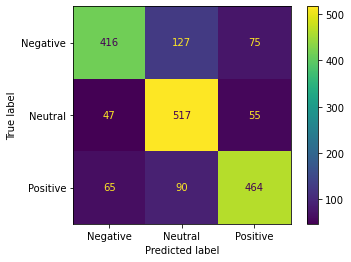

In [104]:
fig, ax = plt.subplots()
plot_confusion_matrix(pipeline, 
                      X_test,
                      y_test,
                      labels=pipeline.classes_, 
                      ax = ax)
plt.show()

# Results

While all the pipelines performed relatively similarly and resulted in macro average f1-scores in a range between 0.60 and 0.69, both pipeline 1 and pipeline 4 performed the best on our dataset, each yielding a macro average f1-score of 0.69 on the validation set. Subsequently, we performed a grid search on both of them, to optimize the hyperparameters max_features, min_df for the vectorizers and alpha, max_iter, loss and penalty function for the Stochastic Gradient Descent classifier. Even though the performance improved substantially for both of the pipelines after the grid search, the optimized hyperparameters resulted in the best performance for pipeline 4, including Tf-Idf Vectorizer and Stochastic Gradient Descent Classifier. To be more precise, the grid search on pipeline 1 resulted in a macro average precision of 0.74 and a macro average recall and f1-score of 0.72. The grid search on pipeline 4 resulted in a macro average precision of 0.77 and a macro average recall and f1-score of 0.76. Therefore, we built a new pipeline including the optimized parameters of pipeline 4, retrained the new pipeline on the merged training and validation sets,  and predicted on the test set that had been kept separate until now. This resulted in a macro average f1-score and recall of 0.75 as well as a macro average precision of 0.76. The f1-scores for the classes seem to be more or less equally distributed, whereas the “Neutral” is a clear outlier in recall score. This is a general tendency that can be observed in most of the pipelines included in this project, and is also reflected in the confusion matrix. Generally speaking, this new pipeline performed relatively well on the test set after hyperparameter optimization. 

Pipeline 2, including CountVectorizer and Support Vector Machines classifier,  resulted in the lowest performance on our data, reaching a macro average f1-score of 0.60. The individual f1-scores ranged between 0.56 and 0.65, with the “Neutral” class being an upward outlier in precision, recall and f1-score. 
